![HenryLogo](https://d31uz8lwfmyn8g.cloudfront.net/Assets/logo-henry-white-lg.png)

# Fraude en TC

¡Bienvenidos al segundo dataset del Hackathon! Nos ponemos ahora en la piel de un Junior Data Scientist trabajando para la financiera Plasma S.A., dedicada a emitir las tarjetas AMEX en distintos países de latinoamerica. 

## Descripción del Problema

Con los últimos avances tecnológicos en lo que respecta a pagos digitales, nuevas generaciones de ciber delincuentes entran en juego y burlan los sistemas de los mayores bancos y compañías financieras del mundo.

El fraude continua siendo muy común para compras online y presenciales. Al existir una magnitud gigante de transacciones que ocurren diariamente, la detección de fraude se presenta como un desafío para los autores involucrados, tanto compañías financiaras como instituciones gubernamentales.

Debido a la situación actual, se crea un equipo antifraude perteneciente al área de Data Science. Como primer task a realizar en el recién creado equipo, nuestro Team Lider nos pide que armemos un modelo para predecir si cierta transacción realizada con tarjeta de crédito es fraudulenta o no, para agilizar los procesos.

Nuestra meta es plantear un modelo (o serie de ellos), correrlo y utilizar la métrica definida para testear su performance.

## Métrica a utilizar

Se utilizará para evaluar el desempeño del/los modelo/s la precisión (acurracy) de la matriz de confusión (confusion matrix).

$$ Accuracy=\frac{TP+TN}{P+N}$$

siendo $TP$ los verdaderos positivos, $TN$ verdaderos negativos y $P+N$ población total.


## Archivos provistos

Nos proveen el archivo fraude_tc.csv, un  .csv con 1M filas (sin contar header) y 8 columnas con información sobre compras con tarjeta de crédito, entre las cuales se incluye la variable a predecir.

## Descripción de las dimensiones

distancefromhome - la distancia a la que la transacción ocurrió desde la dirección de facturación
distancefromlast_transaction - la distancia de la última transacción
ratiotomedianpurchaseprice - ratio de el monto de transacción sobre la mediana 
repeat_retailer - si la transacción se dió sobre un retailer repetido
used_chip - si la transacción es por chip
usedpinnumber - si la transacción es por PIN
online_order - si la transacción es online
fraud - si la transacción fue o no fraudulenta


Esta es la solución propuesta de Jonathan Deiloff

## Librerías necesarias

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import tree
import time
import warnings
warnings.filterwarnings(action="ignore") # Evita mostrar advertencias en las salidas de la ejecución de celdas.

## Ingesta de archivos y análisis preliminar

In [25]:
df = pd.read_csv('fraude_tc.csv')

In [26]:
df.head() # Vistazo para verificar estructura de los datos y que haya sido bien ingestado.

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


## EDA

Procedo a realizar una exploración analítica de los datos, primero verificar cuántos datos son, luego graficar las relaciones entre las dimensiones y finalmente buscar la correlación entre las variables.

In [27]:
df.info() # Info sobre la cantidad de columnas, nulos y tipos de datos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


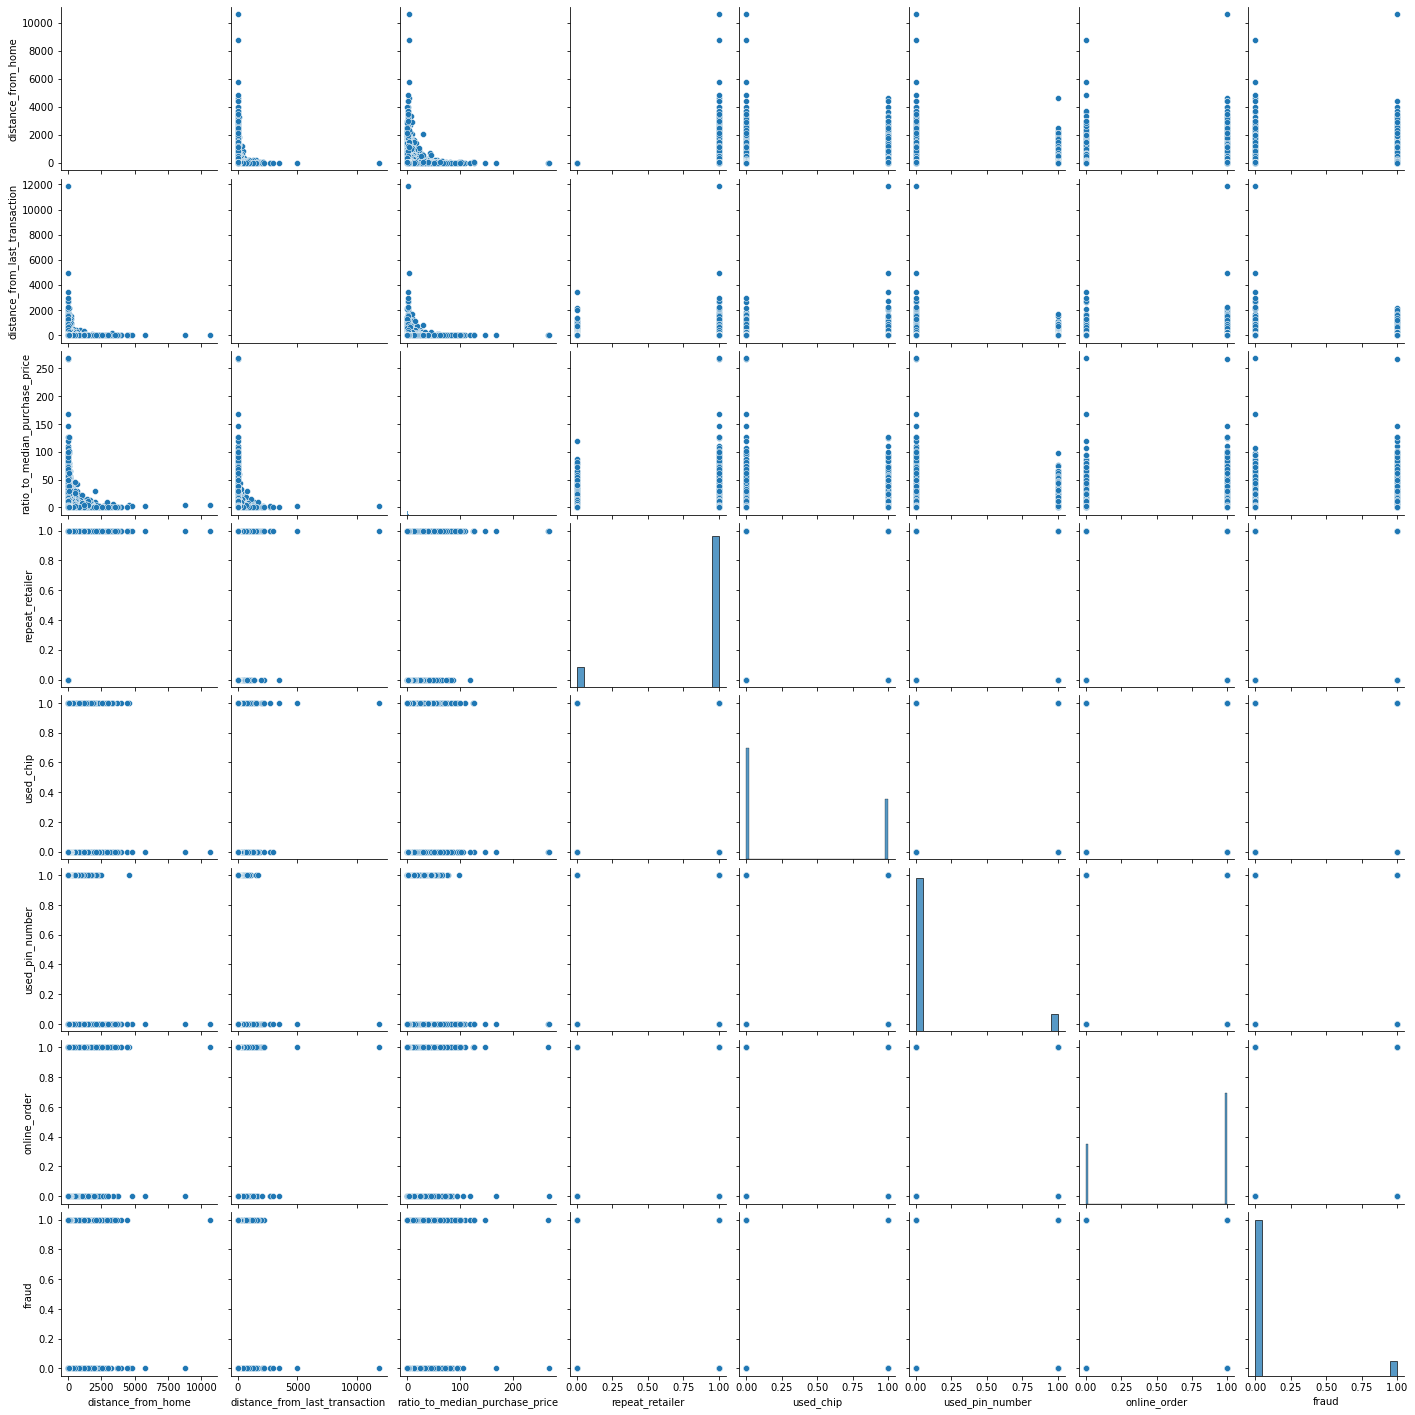

In [28]:
sns.pairplot(df)

Podemos notar de los gráficos anteriores, que las transacciones que se realizaron usando el número de PIN no tienen a ser fraudulentas, y que la mayoría de los fraudes fueron realizados para órdenes de compra online.


<AxesSubplot:>

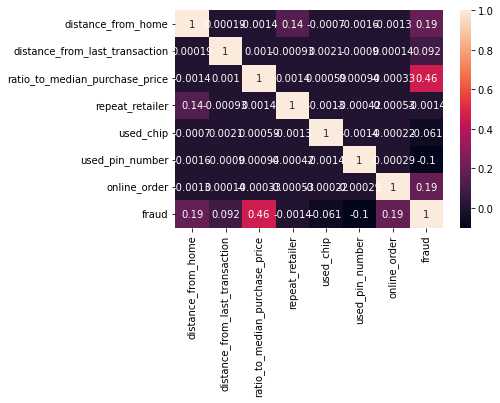

In [29]:
# Correlaciones
corr = df.corr()
sns.heatmap(data=corr, annot=True)

Notamos que la correlación entre las variables es baja, y que la correlación con fraude es más significativa entre la distancia desde casa (distance_from_home), órdenes de compra en línea (online_order) y la proporción del monto de transacción sobre la mediana (ratio_to_median_purchase_price)

## Preparación y entrenamiento del modelo

En este tipo de problemas, donde se deben detectar eventos muy escasos (anomalías), hay que prestar atención que hay cierto balance a conseguir, si uno pondera la tasa de falsos negativos, evita tener problemas con los clientes que legítimamente están intentando comprar, pero debe hacerse cargo del costo asociado a la anulación del pago fraudulento por parte del banco, si tiene muchos falsos positivos, la relación es la contraria, traería muchos problemas con los clientes al tener compras válidas etiquetadas como fraudulentas, pero se ahorraría el costo de la anulación del pago fraudulento ya acreditado. No se observan nulos, o valores categóricos a codificar, por lo que se procede a crear y entrenar el modelo predictivo a utilizar. Para ello se eligió el modelo RandomForestClassiffier por ser un problema de clasificación y no de regresión y tiende a dar muy buenos resultados para la detección de anomalías, como los fraudes con tarjeta de crédito.

In [30]:
X = df.copy()
y = X['fraud']
X = X.drop('fraud', axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [31]:
# Entrenamiento del modelo, hiperparámetros seleccionados a mano.
rfc = RandomForestClassifier(n_estimators=5, max_depth=12, random_state=5)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

## Matriz de confusión
La matriz de confusión permite observar la tasa de valores clasificados como verdaderos positivos y negativos y falsos positivos y negativos. A partir de ella es posible calcular los distintos scores de clasificación, como el f1-score (relación entre accuracy y recall), accuracy (precisión, la proporción de positivos correctos sobre todos los etiquetados como positivos), y recall (exhaustividad, de todos los positivos correctos totales, cuántos fueron etiquetados como positivos).

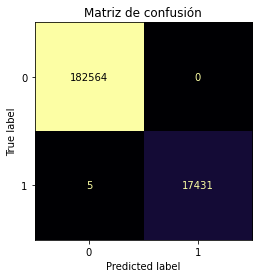

In [32]:
# Matriz de confusión
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='inferno', colorbar=False)
plt.title('Matriz de confusión')
plt.show()

Observamos de desde classification_report, que devuelve un diccionario con los scores calculados en base a la matriz de confusión, la precisión.

In [33]:
# Puntajes
reporte_matriz = classification_report(
    y_true=y_test, y_pred=y_pred, output_dict=True)
accuracy = reporte_matriz['accuracy']
print(f'La precisión del modelo es de {accuracy}')

La precisión del modelo es de 0.999975


## Creación del archivo csv con las predicciones

In [35]:
prediccion_df = pd.DataFrame(y_pred)
prediccion_df = prediccion_df.rename(columns={0:'pred'})
prediccion_df.to_csv("predicciones.csv", index=False)